In [30]:
import sys
sys.path.insert(0, r"C:\Users\sama\Desktop\huobi")
import warnings
import pandas as pd
import numpy as np
from datetime import datetime
from data.dbengine import get_db_engine
from data.dbengine import get_db_klines
import backtest.backtest as bt
import backtest.backtest_analyse as ba
import CTA.CTA_signal as sg
import CTA.costant as cs
import matplotlib.pyplot as plt
import CTA.help_function as hf
from pyfinance.ols import PandasRollingOLS
warnings.filterwarnings('ignore')

engine = get_db_engine('data', 'hbdata')
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


market_data_folder_1h = cs.market_data_folder_1h
start_index = 0
plt.ioff()

################ Settings #############################   
CONTROL_OPEN = False
LIQUIDITY_WEIGHTED = False

ModuleNotFoundError: No module named 'pyfinance'

In [24]:
data_price = pd.read_pickle('{}/combined_close.pkl'.format(market_data_folder_1h))
data_price = data_price[start_index:-1:8]

In [25]:
def reversion(price,window_size,rolling_size, std_factor):
    window_return = (price - price.shift(window_size))/price.shift(window_size)
    mean_return = window_return.rolling(window = rolling_size).mean()
    std_return = window_return.rolling(window = rolling_size).std()
    
    return_pos = mean_return + std_factor*std_return
    return_neg = mean_return - std_factor*std_return
    
    pos = -((window_return > return_pos)).astype(int)
    pos[(window_return < return_neg)] = 1
    

# # For longer holding period:
#     holding_period = 1
#     for k in range(holding_period):
#         pos[(pos == 0) &(pos.shift(1) == 1)&(pos.rolling(holding_period).mean() != 1)&(pos.rolling(holding_period).std() != 0)] = 1
#         pos[ (pos == 0)&(pos.shift(1) == -1)&(pos.rolling(holding_period).mean() != -1)&(pos.rolling(holding_period).std() != 0)] = -1

    return pos

In [26]:
final = pd.DataFrame()
column_names = []
for m in range(60,490,60):
    for n in range(1,5,1):
# for m in range(60,70,100):
#     for n in range(4,5,10):

        target_portfolio = pd.DataFrame()
        for coin in cs.coin_list[:-1]:
            data = data_price[coin]
            if LIQUIDITY_WEIGHTED:
                coef_temp = coef_df.loc[coin]['coef']
            else:
                coef_temp = 1

            pos = pd.Series(reversion(data,1,m,n),index=data.index)
            pos[pos > 0] = 100 * coef_temp
            pos[pos < 0] = -100 * coef_temp
            target_portfolio = pd.concat([target_portfolio, pos], axis=1)


        data_price_4h = data_price
        target_portfolio.columns = cs.coin_list[:-1]
        target_portfolio_4h = target_portfolio.copy()

        ########################## use 1h data ####################################
        data_price_1h = pd.read_pickle('{}/combined_close.pkl'.format(market_data_folder_1h))
        target_portfolio_4h_share = target_portfolio_4h / data_price_4h  # combined

        target_portfolio_4h_share.fillna(0, inplace=True)

        temp_df = pd.DataFrame(index=data_price_1h.index)
        target_portfolio_4h_share = pd.concat([target_portfolio_4h_share, temp_df], axis=1)
        target_portfolio_4h_share.ffill(inplace=True)
        target_portfolio_4h_share.fillna(0, inplace=True)

        # 
        bt_result_4h = bt.backtest(data_price_1h,
                                target_portfolio_4h_share,
                                target_as_share=True,
                                cost_bps=0,  # trading cost model in bps
                                fin_bps=0.0,  # financial cost model in bps
                                delay_day_execution=0)  # need to change to 1 if want to test for result 1 hour delay
                                # delay_day_execution=1)  # need to change to 1 if want to test for result 1 hour delay
        bt_stats_all_4h = ba.statistics(bt_result_4h, trading_bars_year=365 * 24)
        final = pd.concat([final,bt_stats_all_4h["All"]],axis = 1)
        column_names.append(f"{m}_{n}")
final.columns = column_names        

In [27]:
print('4h signal, 1h Data:\n', bt_stats_all_4h, '\n')

4h signal, 1h Data:
 index                All    2018      2019      2020
ret_pct          279.32%    nan%   793.34%   138.33%
ret_pct_maxbs      2.88%    nan%    10.87%     2.49%
volat_pct        1025.5%    nan%  1058.23%   829.22%
sharpe          0.272371     NaN  0.749679  0.166816
tvr              3.55362       0   1.63886   6.18388
tvr_rate          23.56%    nan%     23.8%    23.49%
rot_bps          13.5358     NaN   38.0461   6.72278
daily_pnl       0.115443       0  0.149646  0.099775
daily_volat      8.09753       0    3.8136   11.4269
mdd             -187.876       0  -58.7789  -187.876
booksize         15.0857       0    6.8849   26.3274
abs_booksize     15.0857       0    6.8849   26.3274
max_booksize      1464.4       0   502.361    1464.4
min_booksize           0       0         0         0
gini_coef          3.034     NaN    1.0709    5.6959
gini_negative     0.7731     NaN    0.7343     0.696
Month_winratio     73.0%    0.0%     54.0%     50.0%
Week_winratio      75.0% 

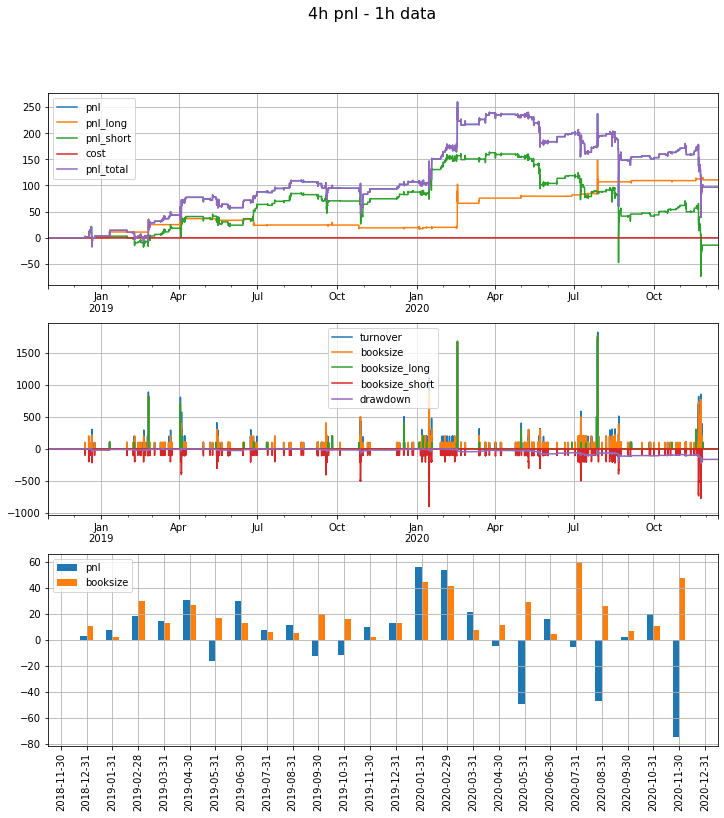

In [12]:
ba.plot_pnl_portfolio(bt_result_4h, title="4h pnl - 1h data")
plt.show()

In [18]:
bt_result_4h['split_pnl'].sum()

ADA      20.272741
ALGO     30.009660
ATOM      8.867380
BAT      23.009786
BCH      30.019305
BTC       0.000000
COMP     10.202788
DASH     30.594393
DOGE     -7.719546
DOT      -2.160643
EOS      35.329381
ETC      53.979916
ETH       4.147351
ICX      -8.938131
IOST     60.723034
IOTA     17.998498
KNC       5.077941
LINK     14.741413
LTC      36.148136
NEO      40.717979
OMG      39.717173
ONT      57.448926
QTUM     15.577627
STORJ    43.370051
THETA     4.582298
TRX      37.967454
UNI       3.315383
VET      66.274775
WAVES     8.320328
XLM       9.742821
XMR      17.722169
XRP       9.580745
XTZ      40.266824
YFI       1.380041
YFII     -6.917992
ZEC      81.669831
ZIL      16.765189
ZRX       5.830039
dtype: float64

In [29]:
final.to_csv("BTC_8h_reversion.csv")

In [ ]:
4h signal, 1h Data:
 index                All      2018      2019      2020
ret_pct         2007.31%  3604.39%  1580.68%  2190.19%
ret_pct_maxbs     12.42%    80.81%    22.77%    17.57%
volat_pct        911.44%   672.52%   583.89%   974.61%
sharpe           2.20235   5.35949   2.70713   2.24725
tvr              9.75708   4.34856   7.84511   12.7075
tvr_rate          48.54%    48.49%    48.23%    48.75%
rot_bps          47.2081   84.8595   37.4158    51.289
daily_pnl        1.10547  0.885641  0.704475   1.56421
daily_volat      9.58977   3.15705   4.97168   13.2981
mdd             -101.726  -12.4761  -52.7898  -101.726
booksize         20.1014    8.9685   16.2673    26.068
abs_booksize     20.1014    8.9685   16.2673    26.068
max_booksize     3249.99       400   1129.32   3249.99
min_booksize           0         0         0         0
gini_coef         0.7015    0.5593    0.5167    0.7565
gini_negative     0.6451    0.5593    0.5109    0.6643
Month_winratio     81.0%     67.0%     85.0%     67.0%
Week_winratio      71.0%     90.0%     75.0%     65.0%
Day_winratio       82.0%     94.0%     86.0%     77.0%
ActiveRate        11.74%     6.55%    10.36%    14.08% 

In [ ]:
ADA      20.272741
ALGO     30.009660
ATOM      8.867380
BAT      23.009786
BCH      30.019305
BTC       0.000000
COMP     10.202788
DASH     30.594393
DOGE     -7.719546
DOT      -2.160643
EOS      35.329381
ETC      53.979916
ETH       4.147351
ICX      -8.938131
IOST     60.723034
IOTA     17.998498
KNC       5.077941
LINK     14.741413
LTC      36.148136
NEO      40.717979
OMG      39.717173
ONT      57.448926
QTUM     15.577627
STORJ    43.370051
THETA     4.582298
TRX      37.967454
UNI       3.315383
VET      66.274775
WAVES     8.320328
XLM       9.742821
XMR      17.722169
XRP       9.580745
XTZ      40.266824
YFI       1.380041
YFII     -6.917992
ZEC      81.669831
ZIL      16.765189
ZRX       5.830039